# ME 7220 Assignment 3
Aidan Clark

Student No. 20191990

## Excercise 3.1 - Direct collocation of a 2D quadcopter**

The following code defines a system model for a 2D quadcopter. The quadcopter is reqreuid to go from start pose
$(px=-1,py=2,\theta=10^{\circ})$ to end pose $(px=5,py=-2,\theta=0^{\circ})$ using a minimal effort optimality for the trajectory. Use a running cost of $u^TRu$ with $R=I_2$. Complete the (#ENTER YOUR MODIFICATIONS HERE) secction to implement a direct collocation type trajectory planner for the task. The quadcopter has a max thrust of $5*m*g$ and it cannot produce reverse trhust. Also assume the ground leven is at $y=-3$. and there is a wall to the left of the diagram at $x=-3$ meters.

Complete the mathematical program and plot the (x,y) trajectory of the generated path.

In [11]:
import matplotlib as mpl
from IPython.display import HTML
from matplotlib import rc
import matplotlib.animation as animation
rc('animation', html='jshtml')
def animate_2Dquad(X,U,T,param,robot_scale=1.5,frame_num=100,speedup=10,tail=100):
  # X, U , T are the state input and time vectors
  #robot_scale =0.5;
  dt=param[0]
  fig = plt.figure()
  ax = fig.add_subplot(aspect='equal')
  ax.set_xlim(-2.2, 6.2)
  ax.set_ylim(-2.2, 2.2)
  # from svg in onshape- https://cad.onshape.com/documents/0025875f07c2427c8fe3436c/w/702252847b1dcbe22315c39c/e/616f7d899244a29ab83281b5?renderMode=0&uiState=6450db4be0083461f05ccb8a
  drone_points = np.array([[0,0.034],[0.058,0.034],[0.120,0.020],[0.261,0.020],[0.261,0.051],[0.254,0.051],[0.228,0.030],[0.215,0.030],[0.075,0.054],[0.467,0.054],[0.319,0.030],[0.312,0.030],[0.285,0.049],[0.285,0.051],[0.278,0.051],[0.278,0.020],[0.319,0.020],[0.337,0],[0.319,-0.017],[0.149,-0.017],[0.120,-0.044],[0.066,-0.044],[0.058,-0.069],[0,-0.069]])
  drone_points_mirror =  np.flip(drone_points @ np.array([[-1 , 0], [ 0, 1]]), axis=0) #np.flip(-drone_points, axis=0);
  drone_points_all = np.append(drone_points , drone_points_mirror, axis=0)
  triangle = ax.add_patch(plt.Polygon(drone_points_all*robot_scale, True))
  line, = ax.plot([0, 0,3], [0, -1,5], lw=1, c='c', alpha=0.5) # draw a line
  line.set_data([0],[0])
  transform = mpl.transforms.Affine2D().rotate_deg(-45) + mpl.transforms.Affine2D().translate(-5,-5)
  triangle.set_transform(transform+ax.transData)

  # determine skip amount from number of frames
  #frame_num =300
  #speedup =2
  #tail = 100 # this should be passes to the function
  skip = np.floor(len(X)/frame_num)
  if skip < 1:
    skip=1
    frame_num = len(X)
  skip=int(skip)
  out = display(progress(0, 100), display_id=True)
  #print(skip)

  def animate(i):
    #print(i,end=' ')
    out.update(progress(i/frame_num*100, 100))
    transform = mpl.transforms.Affine2D().rotate(X[skip*i][4]) + mpl.transforms.Affine2D().translate(X[skip*i][0],X[skip*i][2])
    triangle.set_transform(transform+ax.transData)
    if i>1:
      if skip*i>tail:
        Xtemp= np.array(X[skip*i-tail:skip*i])
        line.set_data(Xtemp[:,0],Xtemp[:,2])
      else:
        Xtemp= np.array(X[0:skip*i])
        line.set_data(Xtemp[:,0],Xtemp[:,2])

  ani = animation.FuncAnimation(fig, animate, frames=frame_num, repeat=True, interval=int(dt*1000*skip/speedup)) # interval determines speed in ms
  print("Number of frames :",frame_num)
  plt.close()
  return ani


def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

solver is:  SNOPT/fortran
minimum time = 2.978996110482209


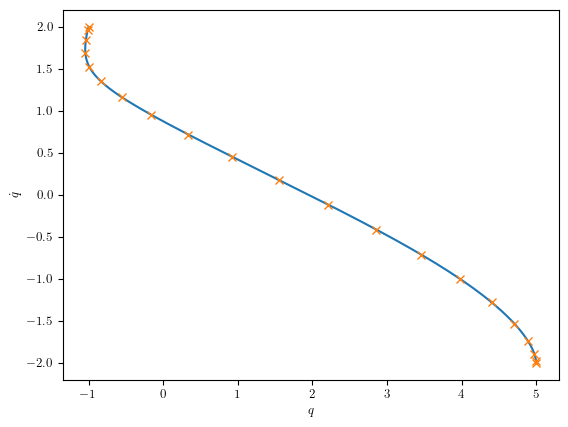

None

/var/folders/cp/7kr1ml951n3fk_kdmlj2xn_r0000gn/T/ipykernel_4235/252894459.py:18: MatplotlibDeprecationWarning: Passing the closed parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  triangle = ax.add_patch(plt.Polygon(drone_points_all*robot_scale, True))


Number of frames : 50


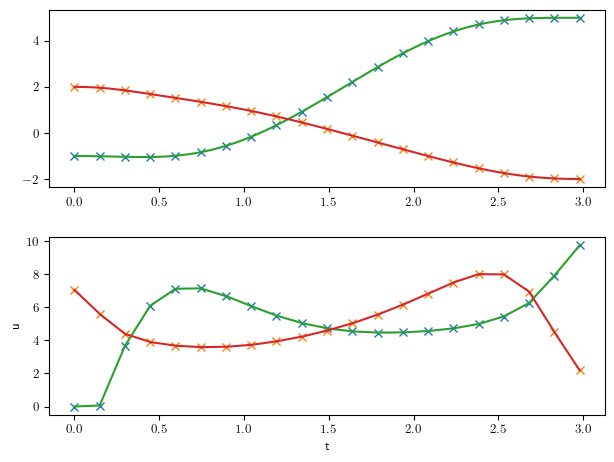

In [14]:
import sys    
path_to_module = '/Users/aidanclark/Documents/MUN Engineering - Academic/AT 7/ME 7220 - GNC/Notes/GNCvenv/GNCmun'
sys.path.append(path_to_module)
from utils_gnc import rotnp
import gnc_animations as gnc

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import pydrake.symbolic
from pydrake.all import (
    DirectCollocation,
    DirectTranscription,
    LinearSystem,
    MathematicalProgram,
    Solve,
    ToLatex,
    Variable,
    eq,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    FiniteHorizonLinearQuadraticRegulator,
    SymbolicVectorSystem,
    PiecewisePolynomial,
)

def dircol_example_2dquad():
      # 1. Define system model:
      # ------Vehicle Parameters-------------
      dt = 0.01; m  = 1.0; g  = 9.81; L = 1.0; r =L; I = 1.0

      # --------Symbolic Variables (x,u)------
      px = Variable("px")
      dpx = Variable("dpx")
      py = Variable("py")
      dpy = Variable("dpy")
      th = Variable("th")
      dth = Variable("dth")
      f1 = Variable("f1")
      f2 = Variable("f2")

      # --------States and State-space Model----
      x = [px, dpx, py, dpy, th, dth]
      u = [f1, f2]
      dx = [  x[1],                           # pxdot = vx
            -(u[0] + u[1]) * pydrake.symbolic.sin(x[4])/m,  # vxdot = -(u1 + u2)sin(theta)/m
            x[3],                           # pydot = vy
            (u[0] + u[1]) * pydrake.symbolic.cos(x[4])/m - g,
            x[5],
            (u[0] - u[1]) * r / I ]
      quad = SymbolicVectorSystem(state=x, dynamics=dx, output=x, input=u)

      #2.------- Mathematical program ------------
      N = 21
      max_dt = 0.5
      dircol = DirectCollocation(
            quad,
            quad.CreateDefaultContext(),
            num_time_samples=N,
            minimum_timestep=0.01,
            maximum_timestep=max_dt,
        )
      prog = dircol.prog()


     #-----------ENTER YOUR MODIFICATIONS HERE-----------------------
      dircol.AddEqualTimeIntervalsConstraints()

      # set input limits at each knot point - dircol has to map it to the mathematical program
      torque_limit = m * g * 5  # 20N
      u = dircol.input()
      x = dircol.state()
      dircol.AddConstraintToAllKnotPoints(x[0] >= -3.0)  # Avoid collision with the left wall
      dircol.AddConstraintToAllKnotPoints(x[2] >= -3.0)  # Avoid collision with the ground
      dircol.AddConstraintToAllKnotPoints(u[0] >= 0.0)   # Non-negative thrust 1
      dircol.AddConstraintToAllKnotPoints(u[1] >= 0.0)   # Non-negative thrust 2
      dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)   # Limit thrust 1
      dircol.AddConstraintToAllKnotPoints(u[1] <= torque_limit)   # Limit thrust 2

      #Set intial and final state- this is doen on the mathmaticla program
      initial_state = [-1.0, 0.0, 2.0, 0.0, np.radians(10), 0.0]
      final_state = [5.0, 0.0, -2.0, 0.0, 0.0, 0.0]
      prog.AddBoundingBoxConstraint(initial_state, initial_state, dircol.initial_state())
      prog.AddBoundingBoxConstraint(final_state, final_state, dircol.final_state())



      #Add running cost and terminal costs
      #As per Q, running cost: u^TRU with R = eye(2)
      R = np.eye(2)
      dircol.AddRunningCost(np.transpose(u) @ R @ u)
      dircol.AddFinalCost(np.transpose(x[0:2] - final_state[0:2]) @ np.eye(2) @ (x[0:2] - final_state[0:2]))


      #-----------DO NOT CHANGE FROM HERE-----------------------

      # set the trajectory to optimze -  initial condition
      initial_x_trajectory = PiecewisePolynomial.FirstOrderHold([0.0, 10.0], np.column_stack((initial_state, final_state)))
      dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

      # 3. Solve-----------------------------------------------
      result = Solve(prog)
      assert result.is_success()
      print('solver is: ', result.get_solver_id().name())
      print(f"minimum time = {dircol.GetSampleTimes(result)[-1]}")

      # 4. Result extraction and visualization-----------------------------------------------
      x_sol = dircol.ReconstructStateTrajectory(result)
      u_sol = dircol.ReconstructInputTrajectory(result)

      #x_solves a polynomial so can be querried for any time t
      X_ref = np.hstack([x_sol.value(t) for t in np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)])
      U_ref = np.hstack([u_sol.value(t) for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000)])
      T_ref = np.linspace(x_sol.start_time(), x_sol.end_time(), 1000)

      # knots values of the splines
      T_knots= x_sol.get_segment_times()
      X_knots = x_sol.vector_values(T_knots)
      U_knots = u_sol.vector_values(T_knots)

      #plot the phase plane plot
      fig, ax = plt.subplots()
      ax.set_xlabel("$q$")
      ax.set_ylabel("$\dot{q}$")
      ax.plot(X_ref[0, :], X_ref[2, :],'-')
      ax.plot(X_knots[0,:], X_knots[2,:],'x')
      display(plt.show())

      #plot the state and input trajectory
      fig, ax = plt.subplots(2, 1)
      fig.tight_layout(pad=2.0)
      ax[0].plot(T_knots, X_knots[0, :].T, "x")
      ax[0].plot(T_knots, X_knots[2, :].T, "x")
      ax[0].plot(T_ref, X_ref[0, :], "-")
      ax[0].plot(T_ref, X_ref[2, :], "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("x")

      ax[1].plot(T_knots, U_knots.T, "x")
      ax[1].plot(T_ref, U_ref.T, "-")
      ax[1].set_xlabel("t")
      ax[1].set_ylabel("u")


      # make the solution as a list for animation
      X=[];U=[];T=[];
      for t in np.linspace(u_sol.start_time(), u_sol.end_time(), 1000):
        T.append(t)
        X.append(x_sol.value(t)[:,0])
        U.append(u_sol.value(t)[:,0])

      dt = T[1]
      param= np.array([dt])
      anim = animate_2Dquad(X,U,T,param,1.0,50,2,150)
      return anim


anim = dircol_example_2dquad()
anim